# Helpful I/O utilities

`torch-biopl` provides a host of utilities to facilitate initializing connectomes, reading in metadata and setting up connectome-constrained models for task-optimization. We will go over a few examples in this tutorial.

In [47]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from bioplnn.utils import create_sparse_projection, load_array, load_tensor

# Let us load in a connectome
save_dir = "connectivity/turaga"
os.makedirs(save_dir, exist_ok=True)
!gdown "https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g" -O "{save_dir}/turaga-dros-visual-connectome.pt"
connectome = torch.load(
    os.path.join(save_dir, "turaga-dros-visual-connectome.pt"),
    weights_only=True,
)

Downloading...
From (original): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g
From (redirected): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g&confirm=t&uuid=5f9e4839-ea40-4cdf-82d7-37f79ca1fa5e
To: /net/vast-storage/scratch/vast/mcdermott/lakshmin/torch-bioplnn-dev/connectivity/turaga/turaga-dros-visual-connectome.pt
100%|████████████████████████████████████████| 111M/111M [00:01<00:00, 66.9MB/s]


### Initializing connectomes with cell type-specific connectivity

`torch-biopl` provides a network initialization utility where users can specify a block matrix of cell-type-to-cell-type connectivities, total population number, and % of population that is each cell type to initialize a connectivity matrix.

In [48]:
from bioplnn.utils import create_neuron_typed_connectome

# total number of neurons in the connectome
num_neurons = 100

# say, your connectome consists of n=5 different cell types
# you can specify the proportion of each cell type relative to the total size of the connectome
n_cell_types = 5
neuron_type_probs = np.array([0.25, 0.3, 0.2, 0.05, 0.2])

# we can interpret these values as exact counts or probabilities.
# in this example, let's treat these are probabilities
deterministic_type_assignment = False

# you can specify cell-type specific connectivity as block matrix.
# non-zero values in this matrix will be treated as percentages.

neuron_type_connectivity_ex01 = np.array(
    [
        [1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1],
    ]
)

neuron_type_connectivity_ex02 = np.array(
    [
        [0, 0.5, 0, 0.0, 0],
        [0, 0, 0.75, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0.5],
        [0.75, 0, 0, 0, 0],
    ]
)

sparse_adjacency_matrix_ex01, neuron_type_assignments_ex01 = (
    create_neuron_typed_connectome(
        num_neurons=num_neurons,
        neuron_type_probs=neuron_type_probs,
        deterministic_type_assignment=deterministic_type_assignment,
        neuron_type_connectivity=neuron_type_connectivity_ex01,
    )
)

sparse_adjacency_matrix_ex02, neuron_type_assignments_ex02 = (
    create_neuron_typed_connectome(
        num_neurons=num_neurons,
        neuron_type_probs=neuron_type_probs,
        deterministic_type_assignment=deterministic_type_assignment,
        neuron_type_connectivity=neuron_type_connectivity_ex02,
    )
)

Let's visualize the synthesized connectome!

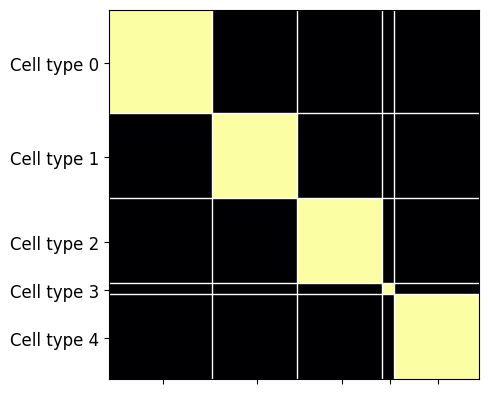

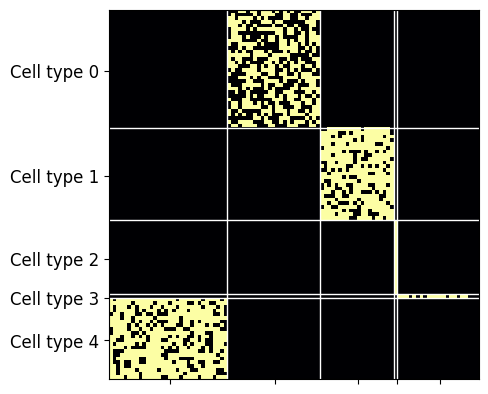

In [49]:
def visualize_connectome(sparse_adjacency_matrix, neuron_type_assignments):
    sorted_indices = np.argsort(neuron_type_assignments)
    dense_connectome = sparse_adjacency_matrix.to_dense()

    # re-arrange the connectome rows and cols to sort by cell type
    dense_connectome = dense_connectome[sorted_indices, :]
    dense_connectome = dense_connectome[:, sorted_indices]

    block_unique, block_start = np.unique(
        np.sort(neuron_type_assignments), return_index=True
    )
    block_centers = [
        (
            block_start[i]
            + (
                block_start[i + 1]
                if i + 1 < len(block_start)
                else len(np.sort(neuron_type_assignments))
            )
        )
        / 2
        for i in range(len(block_unique))
    ]
    block_labels = [f"Cell type {b}" for b in block_unique]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.imshow(dense_connectome, cmap="inferno")

    # label the blocks and draw grid lines to visually separate them
    ax.set_yticks(block_centers)
    ax.set_yticklabels(block_labels, fontsize=12)
    ax.set_xticks(block_centers)
    ax.set_xticklabels([])
    for r in block_start[1:]:
        ax.hlines(
            r - 0.5,
            -0.5,
            dense_connectome.shape[1] - 0.5,
            color="white",
            linewidth=1,
        )
    for c in block_start[1:]:
        ax.vlines(
            c - 0.5,
            -0.5,
            dense_connectome.shape[0] - 0.5,
            color="white",
            linewidth=1,
        )

    # ax.axis('off')


visualize_connectome(
    sparse_adjacency_matrix_ex01, neuron_type_assignments_ex01
)
visualize_connectome(
    sparse_adjacency_matrix_ex02, neuron_type_assignments_ex02
)

### Setting up input and output projections
A common desire for practitioners of connectome-constrained neural network models is to drive neural activity in the connectome through external inputs to a subset of (or all) neurons, and "read out" activity from a subset of (or all) neurons. 

In the case that you want to deal with subsets of neurons for inputs/outputs, it would be more efficient to instantiate these projections to be *sparse*.

In [50]:
# in the case that we are using flattened MNIST images as inputs
num_input_neurons = 28 * 28

# usually, you'd know which neurons receive input.
# here, we are are selecting a random subset.
# if you want all neurons to recieve input, set this to None
input_neuron_indices = torch.randint(
    high=connectome.shape[0], size=(num_input_neurons,)
)

# create the projection matrix
input_projection_matrix = create_sparse_projection(
    size=num_input_neurons,
    num_neurons=connectome.shape[0],
    indices=input_neuron_indices,
    # note the flag
    mode="ih",
)

print(f"input_projection_matrix.shape: {input_projection_matrix.shape}")

input_projection_matrix.shape: torch.Size([47521, 784])


Similarly, you can create output projection matrices as well. You'd want to specify:

1. How many neurons do you want to read out from?
2. What are the indicies of these neurons? 

In [51]:
# decide this based on your connectome and your use case
num_output_neurons = 1000

# specify the indices of the neurons that you want to read out from
# if this is set to "None", the default behavior is to read out from all neurons
output_neuron_indices = torch.randint(
    high=connectome.shape[0], size=(num_output_neurons,)
)

output_projection_matrix = create_sparse_projection(
    size=num_output_neurons,
    num_neurons=connectome.shape[0],
    indices=output_neuron_indices,
    # note the flag!
    mode="ho",
)

print(f"output_projection_matrix.shape: {output_projection_matrix.shape}")

output_projection_matrix.shape: torch.Size([1000, 47521])


### Reading meta data

In most cases, you'll likely have the connectome, cell type information for each neuron in the connectome, and associated information like time constants, leak parameters, etc. for each cell type. You can use in-built methods from `torch-biopl` to read in information in a variety of data formats.

***Strings or integers to identify cell types:***

In [52]:
num_neurons = 100
coin_toss = torch.rand(num_neurons)

# For the purposes of demonstrating loading utilities, let us create some template data for neuron types

# Cell types --> String identifiers
neuron_types_str = np.empty(num_neurons, dtype=object)
neuron_types_str[coin_toss < 0.5] = "neuron_type_A"
neuron_types_str[coin_toss >= 0.5] = "neuron_type_B"
neuron_types_str = neuron_types_str.astype(np.str_)

# Cell types --> Numeric identifiers
neuron_types_int = np.zeros(num_neurons, dtype=int)
neuron_types_int[neuron_types_str == "neuron_type_A"] = 0
neuron_types_int[neuron_types_str == "neuron_type_B"] = 1

# For write purposes, in the case of String identifiers, we can use pandas DataFrames, and in the case of
# numeric identifiers we can use tensors
neuron_types_str_df = pd.DataFrame({"neuron_type": neuron_types_str})
neuron_types_int_tensor = torch.tensor(neuron_types_int)

# Let's save this meta data in a few different ways so we can showcase the read utilities

# saving as *.npys
np.save("connectivity/turaga/neuron_types_str.npy", neuron_types_str)
np.save("connectivity/turaga/neuron_types_int.npy", neuron_types_int)

# saving as a torch tensor
torch.save(
    neuron_types_int_tensor, "connectivity/turaga/neuron_types_int_tensor.pt"
)

# saving as *.csvs
neuron_types_str_df.to_csv("connectivity/turaga/neuron_types_str.csv")

***Loading data***

To load in pre-save meta data information about the connectome, you can leverage the `load_array` and `load_tensor` utilities. These functions adaptively identify file extensions and read in the data accordingly.

In [53]:
loaded_neuron_types_int_np = load_array(
    "connectivity/turaga/neuron_types_int.npy"
).squeeze()
loaded_neuron_types_str_csv = load_array(
    "connectivity/turaga/neuron_types_str.csv"
).squeeze()
loaded_neuron_types_int_pt = load_array(
    "connectivity/turaga/neuron_types_int_tensor.pt"
).squeeze()

You can also load these as tensors directly using the `load_tensor` utility. Please feel free to check it out.